In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt



In [3]:
# leo la imagen en escala de grises

img = cv.imread('C:/Users/c679529/Documents/GitHub/Computer_Vision1/Material_TPs/fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
img.dtype

dtype('uint8')

In [4]:
#Creo funciones para armar Filtros convolucionales y aplicarlos a las imagenes 

def create_gauss_filter(h, w, k_size=5, sigma=5, return_fourier_transform=False):
    """
    Crea un filtro gaussiano de tamaño h x w.

    Args:
        h (int): Altura del filtro.
        w (int): Ancho del filtro.
        k_size (int): Tamaño del kernel gaussiano (por defecto: 5).
        sigma (int): Valor de sigma para el kernel gaussiano (por defecto: 5).
        return_fourier_transform (bool): Indica si se debe devolver la transformada de Fourier.

    Returns:
        np.ndarray: Filtro gaussiano de tamaño h x w.
        Optional[np.ndarray]: Transformada de Fourier del filtro (si return_fourier_transform es True).
    """
    kernel = cv.getGaussianKernel(k_size, sigma)
    gauss_filter = np.outer(kernel, kernel.T)
    
    if h > k_size:
        pad = (h - k_size) // 2
        gauss_filter = np.pad(gauss_filter, [(pad, pad), (pad, pad)], mode='constant')
    
    if h < k_size:
        crop = (k_size - h) // 2
        gauss_filter = gauss_filter[crop:crop+h, crop:crop+w]
    
    if return_fourier_transform:
        # Calculo la transformada de fourier 
        f_transform = np.fft.fft2(gauss_filter)
        f_transform_shifted = np.fft.fftshift(f_transform)
        fourier_transform = np.log(np.abs(f_transform_shifted) + 1)
        return gauss_filter, fourier_transform
    else:
        return gauss_filter


def apply_gaussian_filter(image: np.ndarray, k_size=5, sigma=5, return_fourier_transform=False):
    """
    Aplica un filtro gaussiano a una imagen.

    Args:
        image (np.ndarray): Imagen de entrada.
        k_size (int): Tamaño del kernel gaussiano (por defecto: 5).
        sigma (int): Valor de sigma para el kernel gaussiano (por defecto: 5).
        return_fourier_transform (bool): Indica si se debe devolver la transformada de Fourier.

    Returns:
        np.ndarray: Imagen filtrada con el filtro gaussiano.
        Optional[np.ndarray]: Transformada de Fourier del filtro (si return_fourier_transform es True).
    """
    h, w = image.shape
    gauss_filter, fourier_transform = create_gauss_filter(h, w, k_size, sigma, return_fourier_transform=True)
    filtered_image = cv.filter2D(image, -1, gauss_filter)
    
    if return_fourier_transform:
        return filtered_image, fourier_transform
    else:
        return filtered_image




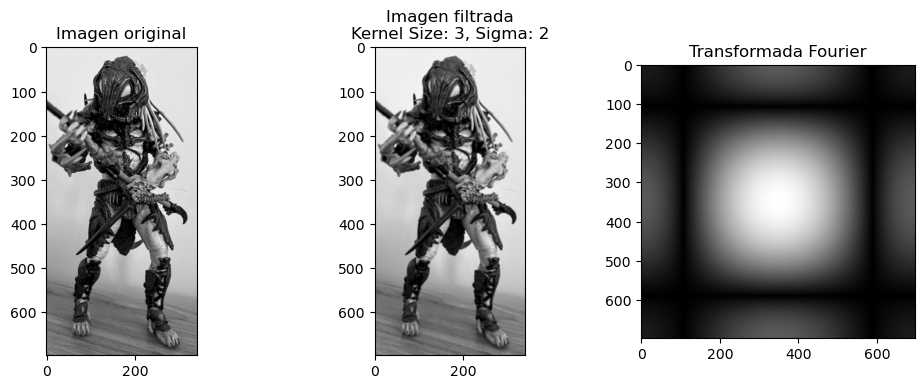

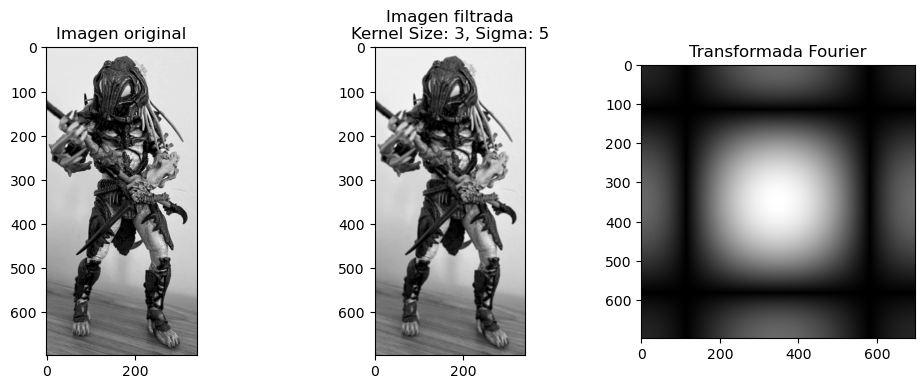

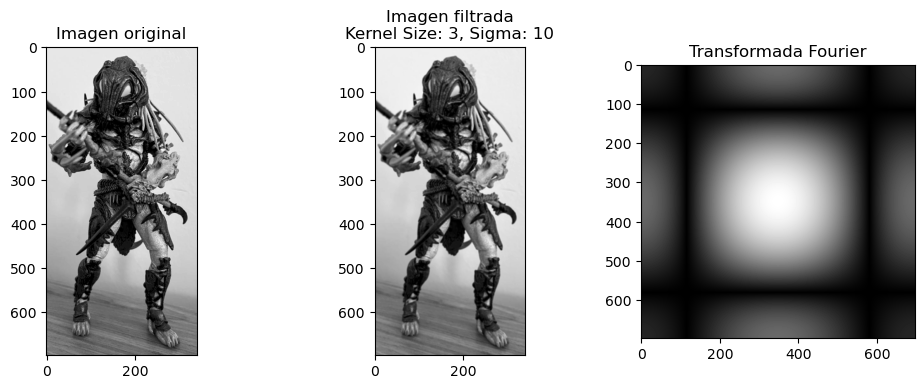

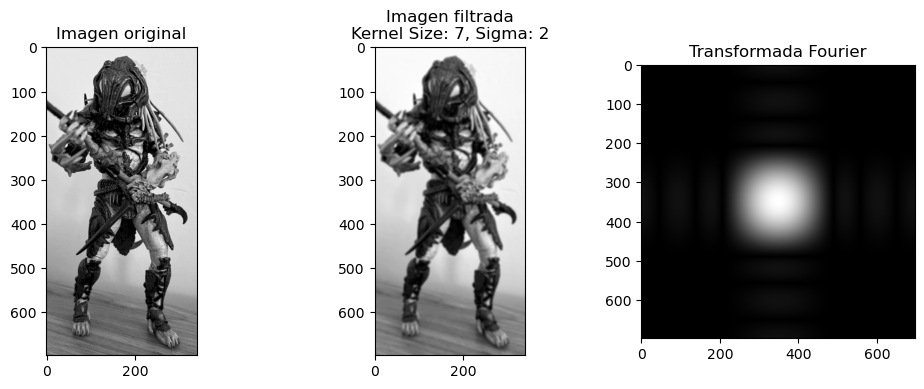

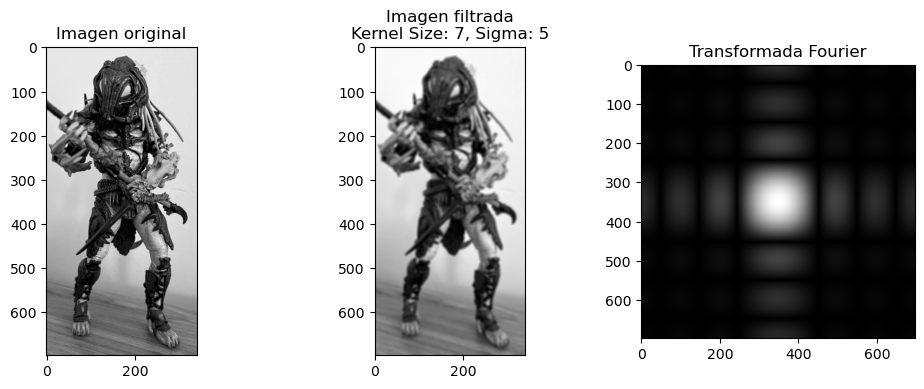

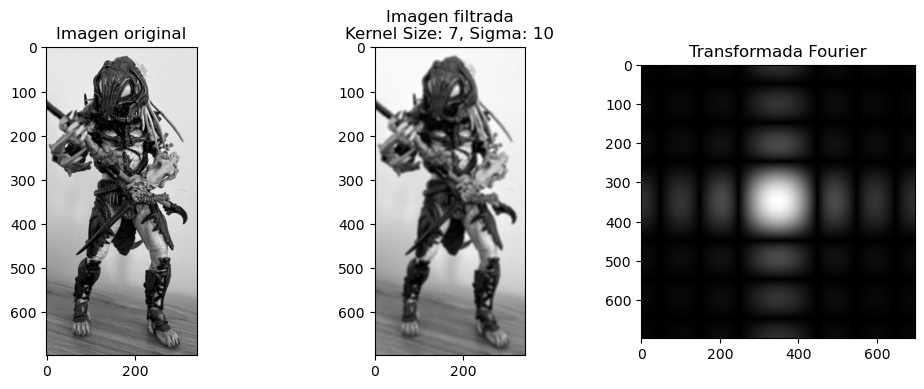

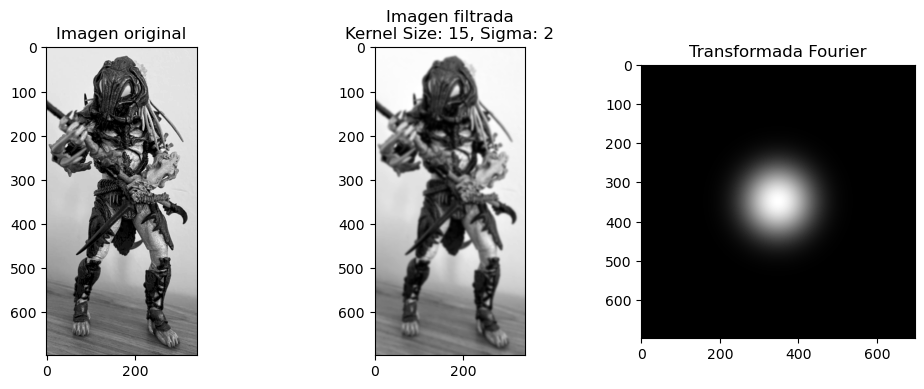

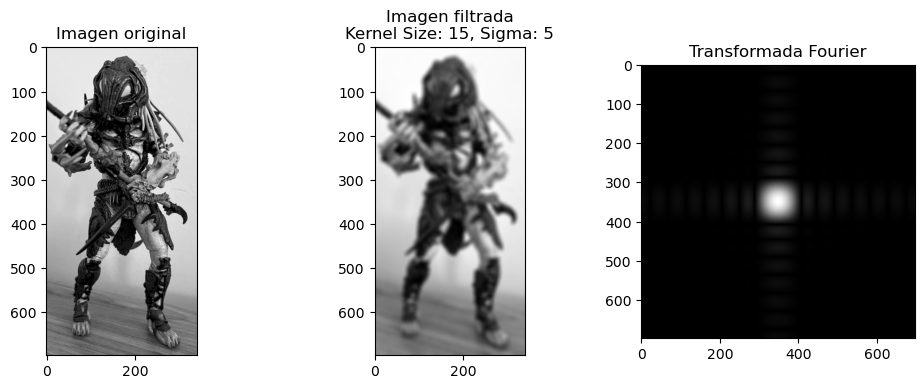

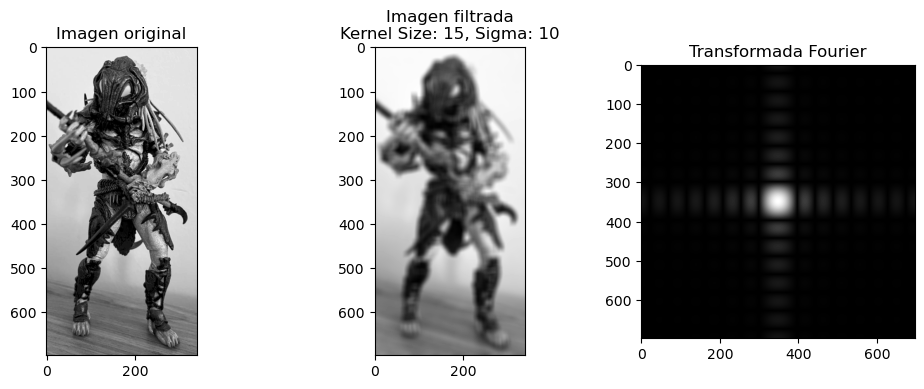

In [19]:
#Armo una funcion para plotear los resultados de la aplicacion de filtros Gaussianos 

def plot_image_and_transform(image, filter_result, transform_result=None, k_size=None, sigma=None):
    plt.figure(figsize=(12, 4))
    
    # Imagen Original 
    plt.subplot(131)
    plt.imshow(image, cmap='gray')
    plt.title('Imagen original')
    
    #Imagen filtrada
    plt.subplot(132)
    plt.imshow(filter_result, cmap='gray')
    plt.title(f'Imagen filtrada\nKernel Size: {k_size}, Sigma: {sigma}')
    
    # Si se solicita transformada de fourier se grafica
    if transform_result is not None:
        plt.subplot(133)
        plt.imshow(transform_result, cmap='gray')
        plt.title('Transformada Fourier')
    
    plt.show()

def test_gaussian_filter(image, k_sizes, sigmas):
    for k_size in k_sizes:
        for sigma in sigmas:
            filtered_image, fourier_transform = apply_gaussian_filter(image, k_size, sigma, return_fourier_transform=True)
            
            # Visualizo los resultados
            plot_image_and_transform(image, filtered_image, fourier_transform, k_size, sigma)
                  

k_sizes = [3, 7, 15]  # Kernels que voy a evaluar
sigmas = [2, 5, 10]  # Sigmas que voy a evaluar 


test_gaussian_filter(img, k_sizes, sigmas)


Como podemos observar de los resultados en las imagenes , el aumento de los Kernels suavizará más la imagen, ya que el filtro abarcará una mayor área. Por el contrario, reducir el tamaño del kernel dará como resultado un suavizado menos pronunciado y más localizado.
Como consecuencia Un kernel más grande tiende a eliminar detalles finos, pero también puede suavizar bordes y transiciones rápidas en la imagen.

En cuanto a los sigmas, Un valor de sigma más grande dará como resultado un suavizado más extenso y una difusión más suave de los píxeles. Un sigma más pequeño producirá un suavizado más localizado y preservará detalles más finos.
los Sigmas controlan la dispersión de la función gaussiana. Un sigma mayor aumenta el alcance del suavizado, mientras que un sigma menor limita el suavizado a regiones más pequeñas.

Al visualizar la transformada de Fourier, se puede observar  cómo cambian las frecuencias en la imagen después de aplicar el filtro gaussiano.un filtro gaussiano con Kernels mas elevados tiene como consecuencia una transformada de fourier totalmente diferente.


In [24]:
#Funciones necesarias para aplicar filtros espectrales con transformada de fourier 

def fft2_mod(image):

  shifted_image_fft = np.fft.fftshift(np.fft.fft2(image))
  return 20*np.log(np.abs(shifted_image_fft))


def _filter_round_shape(height, width, radius):
  canvas = np.zeros((height, width))
  return cv.circle(canvas,
                     center=(int(canvas.shape[1]/2), int(canvas.shape[0]/2)),
                     radius=radius,
                     color=(255),
                     thickness=-1).astype(np.uint8)

def create_lp_filter(height, width, radius=20):

  lp_filter = _filter_round_shape(height, width, radius)
  return lp_filter



In [21]:
h, w = img.shape
lp_filter = create_lp_filter(h, w, radius=40)

In [22]:
# vuelvo a calcular la FFT. Para aplicar el filtro 
# necesito la transformada en modulo y fase en el dominio
# de los numeros complejos
shifted_fft = np.fft.fftshift(np.fft.fft2(img))
lp_filtered = shifted_fft * lp_filter


# Aplicamos la antitransformada y obtenemos las imagenes filtradas
f_ishift = np.fft.ifftshift(lp_filtered)
img_lp = np.real(np.fft.ifft2(f_ishift))


Text(0.5, 1.0, 'Pasa bajos - Blur o desenfoque')

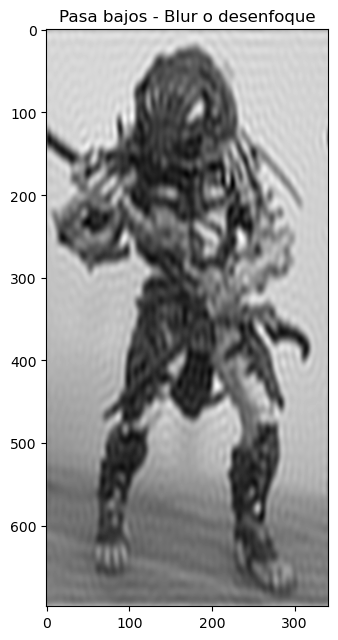

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img_lp, cmap='gray')
plt.title('Pasa bajos - Blur o desenfoque')

In [10]:
#Armo la funcion del paper para medir la calidad de imagen 

def image_quality_measure(image):
    """""
    Args:
        image (np.ndarray): Input image of size M×N.

    Returns:
        float: Image Quality measure (FM).
        
    """
    # Step 1: Computar Transformada de fourier
    F = np.fft.fft2(image)

    # Step 2: Centro el origen
    Fc = np.fft.fftshift(F)

    # Step 3: Calculo el valor absoluto
    AF = np.abs(Fc)

    # Step 4: Calculo el maximo de frecuencia 
    M = np.max(AF)

    # Step 5: calculo el numero total de pixeles
    thres = M / 1000
    TH = np.sum(AF > thres)

    # Step 6: Calculo Image Quality measure (FM)
    FM = TH / (image.shape[0] * image.shape[1])

    return FM



In [11]:
#Punto B)
# Calculate the image quality measure
quality_measure = round(image_quality_measure(apply_gaussian_filter(img, k_size=5, sigma=5, return_fourier_transform=False)),3)
quality_measure_filtered=round(image_quality_measure(img_lp),3)

# Display the result
print(f"Medida de calidad de imagen para filtro convolucional : {quality_measure}")
print(f"Medida de calidad de imagen para filtro espectral con transformada de fourier de pasa Bajos : {quality_measure_filtered}")

Medida de calidad de imagen para filtro convolucional : 0.022
Medida de calidad de imagen para filtro espectral con transformada de fourier de pasa Bajos : 0.017


En este caso puntual se observa una mejor calidad de imagen para un filtro convolucional con Kernel size en 5 y sigma en 5 versus un filtro espectral de bajo con radio en 40


In [12]:
#Punto C)

#Calculo of grey level variance del paper “Analysis of focus measure operators in shape-from-focus"


def calculate_gray_level_variance(image):
    """
    Calculo el gray level variance de una imagen .

    Args:
        image (np.ndarray): Input image.

    Returns:
        float: Gray level variance.
    """
    # Flatten de imagen a un 1Darray
    flattened_image = image.flatten()

    # Calculo la media de la intensidad
    mean_intensity = np.mean(flattened_image)

    # Calculo el grey level variance 
    variance = np.mean((flattened_image - mean_intensity)**2)

    return variance




In [17]:

# Calculo the gray level variance para imagen con filtro gaussiano de Convolucion vs un filtro espectral con transformada de Fourier 
variance_result = round(calculate_gray_level_variance(apply_gaussian_filter(img, k_size=5, sigma=5, return_fourier_transform=False)),1)
variance_result_filtered = round(calculate_gray_level_variance(img_lp),1)

# Display the result
print(f"Gray Level Variance Filtro convolucional Gaussiano: {variance_result}")
print(f"Gray Level Variance Filtro espectral: {variance_result_filtered}")


Gray Level Variance Filtro convolucional Gaussiano: 5287.0
Gray Level Variance Filtro espectral: 345037282.9
